# Import Dependencies

In [12]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

class CIFAR10Dataset(Dataset):
    def __init__(self, X, y, transform=None):
        # convert numpy x to pil
        X = [transforms.ToPILImage()(x) for x in X]
        self.data = X
        self.targets = y
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.targets[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


train_portion = 1/4

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
X, y = train_dataset.data, np.array(train_dataset.targets)
generator = torch.Generator().manual_seed(42)

if train_portion < 1:
    sss = StratifiedShuffleSplit(n_splits=1, test_size=1-train_portion, random_state=42)
    train_idx, _ = next(sss.split(X, y))
    X, y = X[train_idx], y[train_idx]
    print(f'Train {train_portion} in use')
    print(len(train_dataset))

# train valid split

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, valid_idx = next(sss.split(X, y))
X_train, y_train = X[train_idx], y[train_idx]
X_valid, y_valid = X[valid_idx], y[valid_idx]

train_dataset = CIFAR10Dataset(X_train, y_train, transform=transform_train)
valid_dataset = CIFAR10Dataset(X_valid, y_valid, transform=transform_test)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
print(len(train_dataset), len(valid_dataset), len(test_dataset))

from collections import Counter
print(Counter(train_dataset.targets))
print(Counter(valid_dataset.targets))

Files already downloaded and verified
Train 0.25 in use
50000
Files already downloaded and verified
10000 2500 10000
Counter({2: 1000, 6: 1000, 5: 1000, 4: 1000, 7: 1000, 8: 1000, 3: 1000, 0: 1000, 1: 1000, 9: 1000})
Counter({4: 250, 8: 250, 3: 250, 5: 250, 2: 250, 9: 250, 1: 250, 7: 250, 0: 250, 6: 250})


In [14]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
@widgets.interact(i=widgets.IntSlider(min=0, max=len(train_dataset)-1))
def show(i):
    image, label = train_dataset[i]
    print(image.shape, label)
    image = (image + 1) / 2
    plt.imshow(image.permute(1, 2, 0))
    plt.show()

interactive(children=(IntSlider(value=0, description='i', max=39999), Output()), _dom_classes=('widget-interac…

In [15]:

# m = models.swin_t(weights=None, num_classes=10)
m =  models.resnet50(weights=None, num_classes=10) 
# get number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(m)

23528522

In [26]:
class Noscheduler:
    def __init__(self, lr=0.001):
        self.lr = lr
    @staticmethod
    def step():
        pass
    def get_last_lr(self):
        return [self.lr]
    
def prepare_training(model_type = 'resnet50',
                    scheduler='OneCycleLR', 
                    optimizer='SGD',
                    total_steps = 10000,
                    batch_size=1000,
                    lr=0.001, 
                    max_lr=0.01, 
                    end_lr=0.0001,
                    momentum=0,
                    weight_decay=0, 
                    num_workers=2, 
                    num_classes=10):
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    if model_type == 'resnet50':
        model = models.resnet50(weights=None, num_classes=num_classes) 
    elif model_type == 'resnet18':
        model = models.resnet18(weights=None, num_classes=num_classes)
    elif model_type == 'swin_t':
        model = models.swin_t(weights=None, num_classes=num_classes)
    else:
        print('Model not found')
        raise ValueError('Model not found')

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    if optimizer.lower()=='sgd':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    elif optimizer.lower() =='adamw':
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    # maybe use SGD, decay = ...
    # future, use adamw to see if there's any 

    # reduce data of cifar and train on 1 model
 

    if scheduler==None:
        scheduler = Noscheduler(lr=lr)
    elif scheduler=='OneCycleLR':
        scheduler = OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps)
    elif scheduler=='LinearLR':
        scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=end_lr/lr, total_iters=total_steps)
    elif scheduler=='ReduceOnPlateau':
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=total_steps//10, verbose=True)

    return train_loader, valid_loader, test_loader, model, device, criterion, optimizer, scheduler

In [27]:
def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [28]:
class InfiniteDataLoaderIterator:
    def __init__(self, dataloader):
        self.dataloader = dataloader
        self.iterator = iter(dataloader)
    
    def __iter__(self):
        return self
    
    def __next__(self):
        try:
            return next(self.iterator)
        except StopIteration:
            # Reset the iterator
            self.iterator = iter(self.dataloader)
            return next(self.iterator)

def validate(model, valid_loader, criterion, device, scheduler, save_dir=None):
    global best_val_accuracy, metric_dict, scheduler_type
    model.eval()
    val_running_loss = 0.0
    val_total_correct = 0
    val_total_images = 0
    with torch.no_grad():
        for i, data in enumerate(valid_loader):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total_images += labels.size(0)
            val_total_correct += (predicted == labels).sum().item()
        current_val_accuracy = val_total_correct / val_total_images                
        metric_dict['val_step_loss'].append(val_running_loss/(i+1))
        metric_dict['val_step_acc'].append(current_val_accuracy)
        if scheduler_type == 'ReduceOnPlateau':
            metric_dict['lr'].append(scheduler.optimizer.param_groups[0]['lr'])
        else:
            metric_dict['lr'].append(scheduler.get_last_lr()[0])
    
    # Update the best model if current validation accuracy is better
    if current_val_accuracy > best_val_accuracy:
        best_val_accuracy = current_val_accuracy
        os.makedirs(save_dir, exist_ok=True)
        torch.save(model.state_dict(), f'{save_dir}/best_model.pth' )
    model.train()
    val_running_loss = val_running_loss / len(valid_loader)
    current_val_accuracy = val_total_correct / val_total_images
    return val_running_loss, current_val_accuracy

# Learning Rate Test

  0%|          | 0/29 [00:00<?, ?it/s]

<Figure size 2000x1000 with 0 Axes>

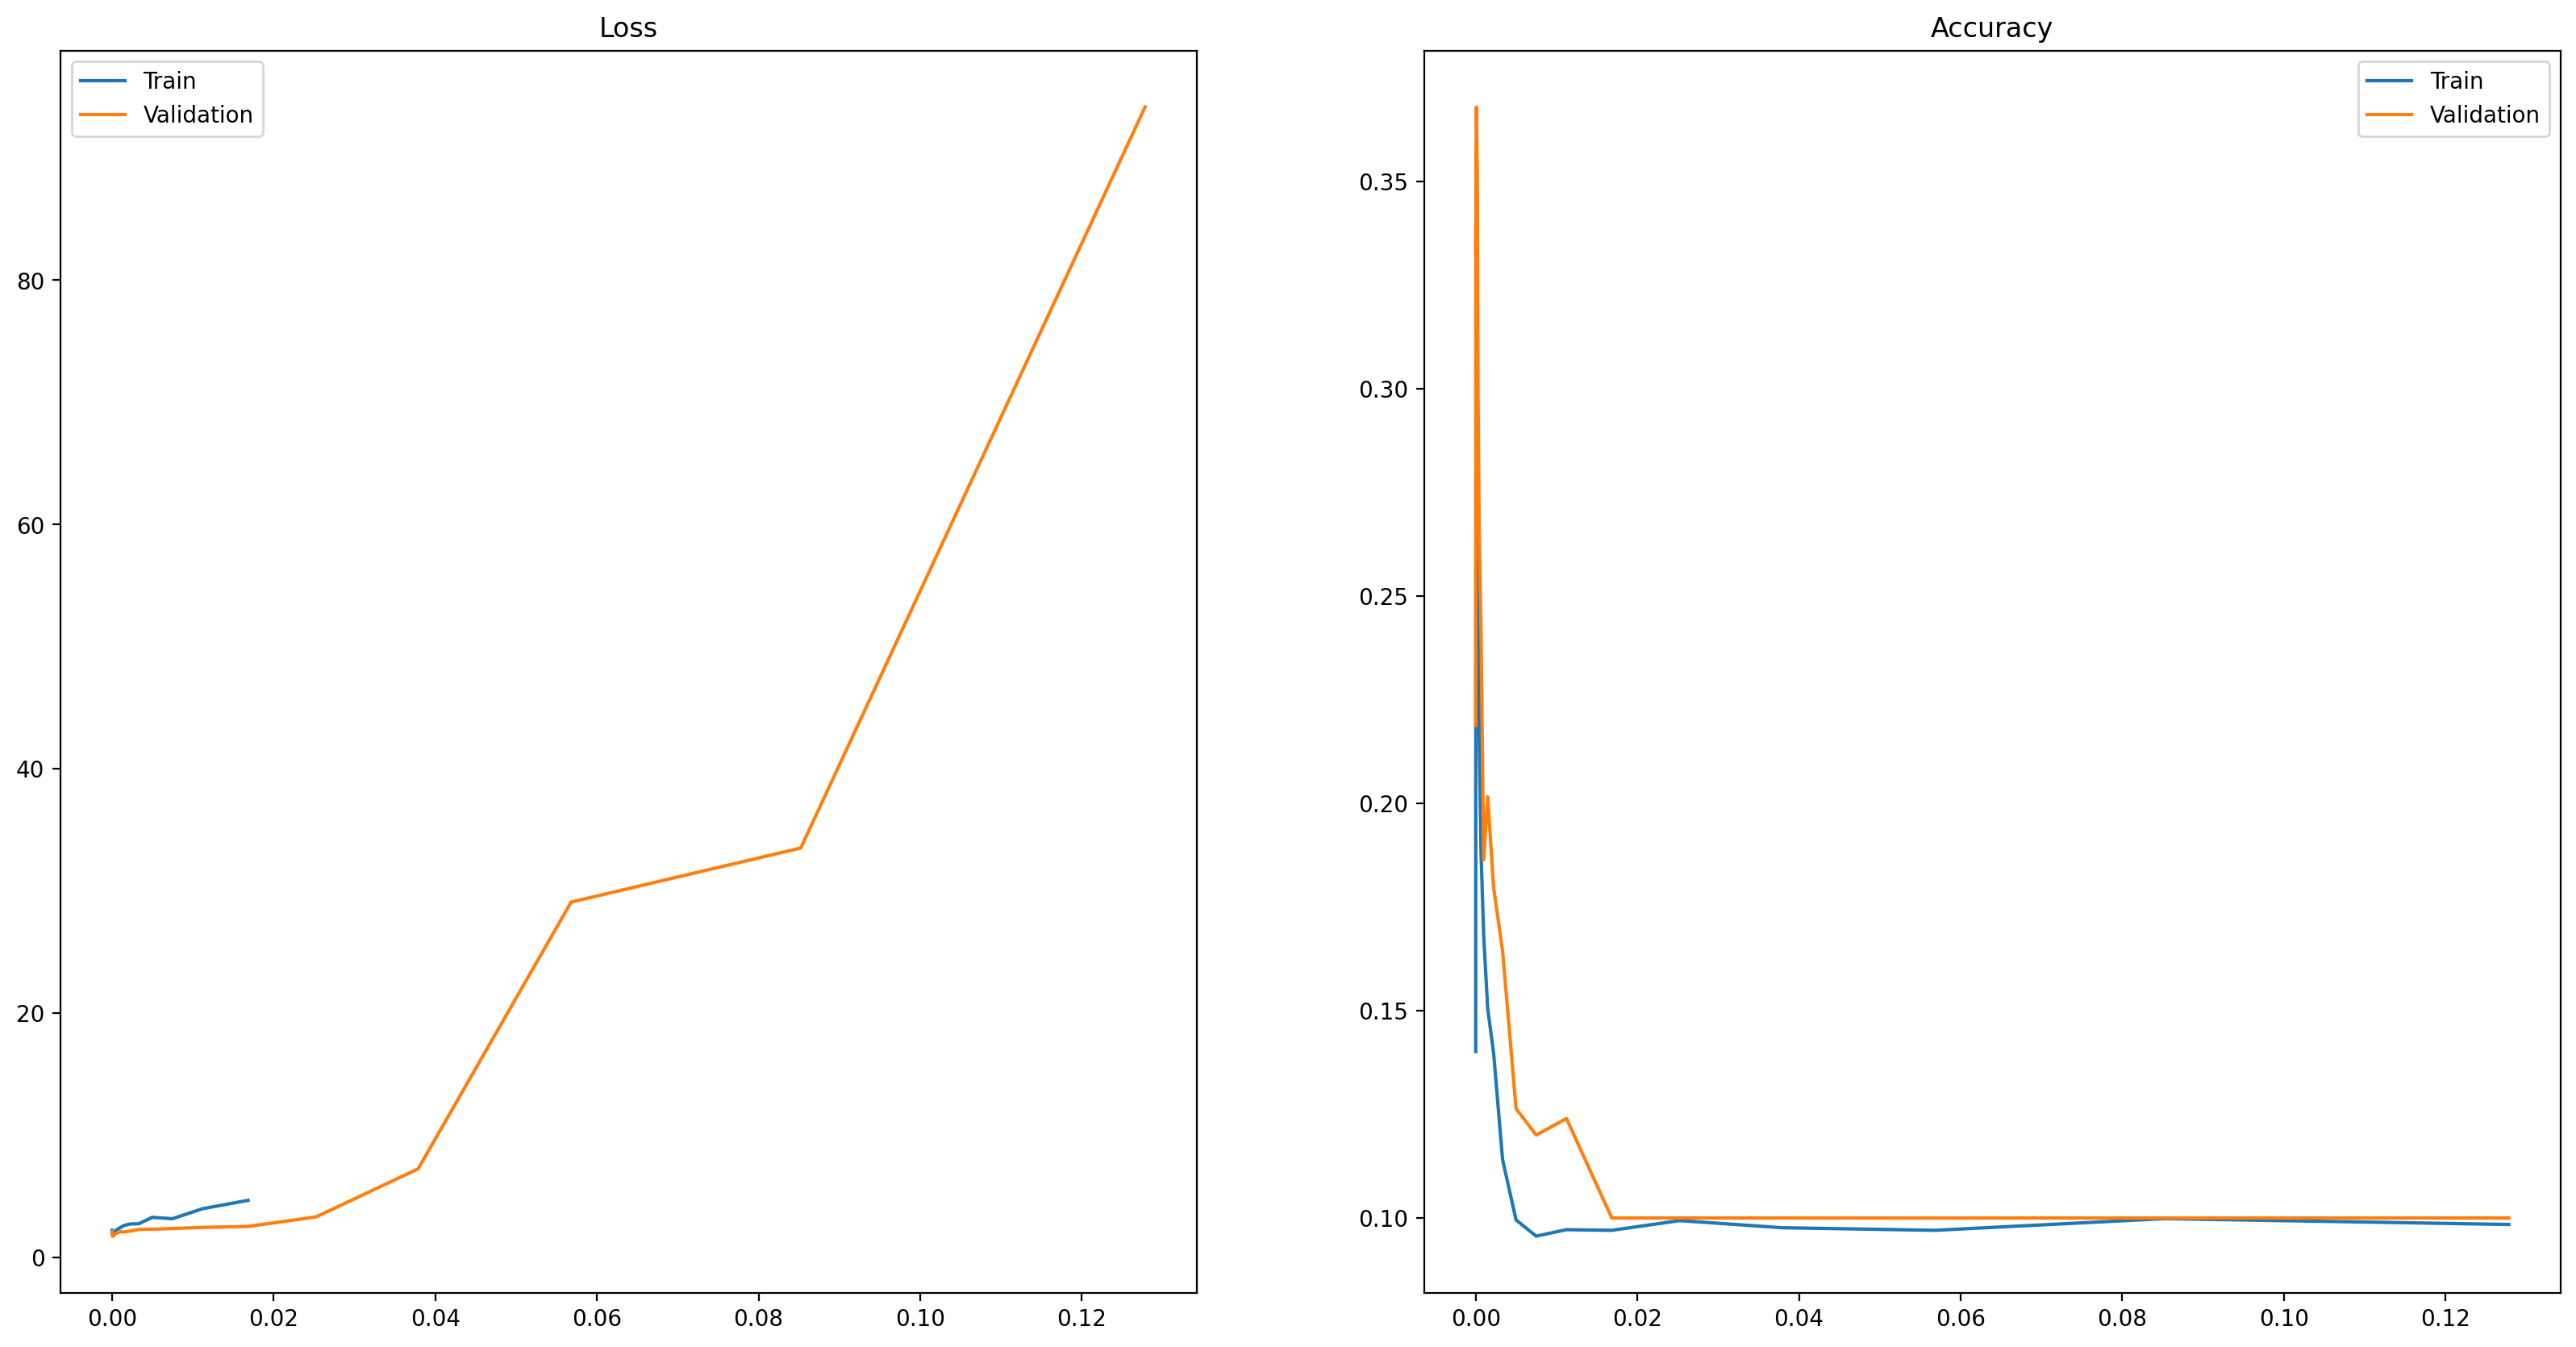

In [21]:
from torch.cuda.amp import GradScaler, autocast 
from tqdm.auto import tqdm 
import numpy as np

max_lr = 0.01
total_steps = 50
eval_interval = 50
batch_size = 128
momentum = 0
weight_decay = 0.005
optimizer_type = 'AdamW'

exp_list = [None]
# [None, 'OneCycleLR']
set_seed(42)
import datetime

time_stamp = str(datetime.datetime.now()).replace(' ', '_').replace(':', '_').replace('.', '_')
exp_name = './results/lr_test'
# model_configs = ['swin_t', 'resnet18']
# model_configs = ['resnet50', 'swin_t', 'resnet18']
model_configs = ['swin_t']



all_results_dict = {}
for model_type in model_configs:
    all_results_dict[model_type] = {}
    loss_too_large = 0
    lr_list = [0.000001*1.5**i for i in range(1, 30)]
    # for lr in (tqdm_bar:=tqdm(np.arange(0.000001, 0.0001, 0.000004))):
    for lr in (tqdm_bar:=tqdm(lr_list)):
        if loss_too_large>20:
            break
        for scheduler_type in exp_list:
            # print(f'Using scheduler: {scheduler_type}')
            train_loader, valid_loader, test_loader, model,\
                device, criterion, optimizer, scheduler = \
                    prepare_training(model_type, scheduler_type, batch_size=batch_size, 
                                     total_steps=total_steps, lr=lr, max_lr=max_lr,
                                     momentum=momentum, weight_decay=weight_decay, optimizer=optimizer_type)
            total_images = len(train_loader.dataset)

            steps_per_epoch = len(train_loader)
            eval_interval = steps_per_epoch if eval_interval is None else eval_interval

            train_loader_iterrator = InfiniteDataLoaderIterator(train_loader)
            metric_dict = {
                'train_loss': [],
                'train_acc': [],
                'val_step_loss': [],
                'val_step_acc': [],
                'val_step_lr': [],
                'lr': []
            }

            scaler = GradScaler()
            best_val_accuracy = 0

            model.train()
            running_loss = 0.0
            total_correct = 0
            for cur_iters in range(total_steps):

                    
                # train step start
                data = next(train_loader_iterrator)
                inputs, labels = data[0].to(device), data[1].to(device)

                optimizer.zero_grad()
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scheduler.step()
                scaler.update()

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_correct += (predicted == labels).sum().item()
                # train step finish


                # Validation phase
                if cur_iters % eval_interval == eval_interval-1 or cur_iters == 0 or cur_iters == total_steps-1:
                    save_dir = f'./{exp_name}/{time_stamp}/{model_type}'
                    val_loss, val_acc = validate(model, valid_loader, criterion, device, scheduler, save_dir)        

                    if val_loss > 10:
                        loss_too_large += 1
                    train_loss = running_loss/eval_interval
                    train_acc = total_correct/(eval_interval*train_loader.batch_size)
                
                    metric_dict['train_loss'].append(train_loss)
                    metric_dict['train_acc'].append(train_acc)
                    metric_dict['lr'].append(scheduler.get_last_lr()[0])

                    desc = ''
                    desc += f'Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.3f}, '
                    desc += f'Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.3f}'
                    tqdm_bar.set_description(desc)
                    running_loss = 0.0
                    total_correct = 0

            # testing
            model.eval()
            total_correct = 0
            total_images = 0
            with torch.no_grad():
                for data in test_loader:
                    images, labels = data[0].to(device), data[1].to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total_images += labels.size(0)
                    total_correct += (predicted == labels).sum().item()
            
            desc = 'Model accuracy on 10000 test images: %d%%' % (total_correct * 100 / total_images)
            tqdm_bar.set_description(desc)

            # print(desc, end='\r')

        all_results_dict[model_type][lr] = metric_dict

    import json
    import matplotlib.pyplot as plt
    new_dir = f'./{exp_name}/{time_stamp}'
    os.makedirs(new_dir, exist_ok=True)

    f_name = f'results_{model_type}'
    with open(f'{new_dir}/{f_name}.json', 'w') as f:
        json.dump(all_results_dict[model_type], f)

    results_dict = json.load(open(f'{new_dir}/{f_name}.json', 'r'))

    figure = plt.figure(figsize=(10, 5), dpi=200)
    
    lr_list = list(results_dict.keys())
    lr_list = sorted(list(map(float, lr_list)))
    lr_list = list(map(str, lr_list))
    train_loss = [results_dict[lr]['train_loss'][-1] for lr in lr_list]
    train_acc = [max(results_dict[lr]['train_acc'])  for lr in lr_list]
    val_loss = [results_dict[lr]['val_step_loss'][-1]  for lr in lr_list]
    val_acc = [max(results_dict[lr]['val_step_acc'])  for lr in lr_list]
    lr_list = list(map(float, lr_list))

    # subplots
    fig, ax = plt.subplots(1, 2, figsize=(20, 10), dpi=200)
    ax[0].set_title('Loss')
    ax[0].plot(lr_list, train_loss, label='Train')
    ax[0].plot(lr_list, val_loss, label='Validation')
    ax[0].legend()


    ax[1].set_title('Accuracy')
    ax[1].plot(lr_list, train_acc, label='Train')
    ax[1].plot(lr_list, val_acc, label='Validation')
    ax[1].legend()

    fig.savefig(f'{exp_name}/{time_stamp}/{f_name}.png')
    # plt.savefig(f'./lr_test/{time_stamp}/{f_name}.png')
    plt.show()

global_configs = {
    'total_steps': total_steps,
    'eval_interval': eval_interval,
    'batch_size': batch_size,
    'max_lr': max_lr,
    'len_train': len(train_dataset),
    'len_val': len(valid_dataset),
    'momentum': momentum,
    'weight_decay': weight_decay,
    'optimizer': optimizer_type,
}
with open(f'{exp_name}/{time_stamp}/global_configs.json', 'w') as f:
    json.dump(global_configs, f)

In [27]:
np.argmax(val_acc)

5

In [23]:
lr_list

[0.000243,
 0.0007289999999999999,
 0.0021869999999999997,
 0.006561,
 0.019683,
 2.7e-05,
 3e-06,
 8.099999999999999e-05,
 9e-06]

# Training

  0%|          | 0/20000 [00:00<?, ?it/s]

Model accuracy on 10000 test images: 65%


  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch 12903: reducing learning rate of group 0 to 9.6000e-05.
Epoch 15905: reducing learning rate of group 0 to 7.2000e-05.
Epoch 18591: reducing learning rate of group 0 to 5.4000e-05.
Model accuracy on 10000 test images: 66%


<Figure size 2000x1000 with 0 Axes>

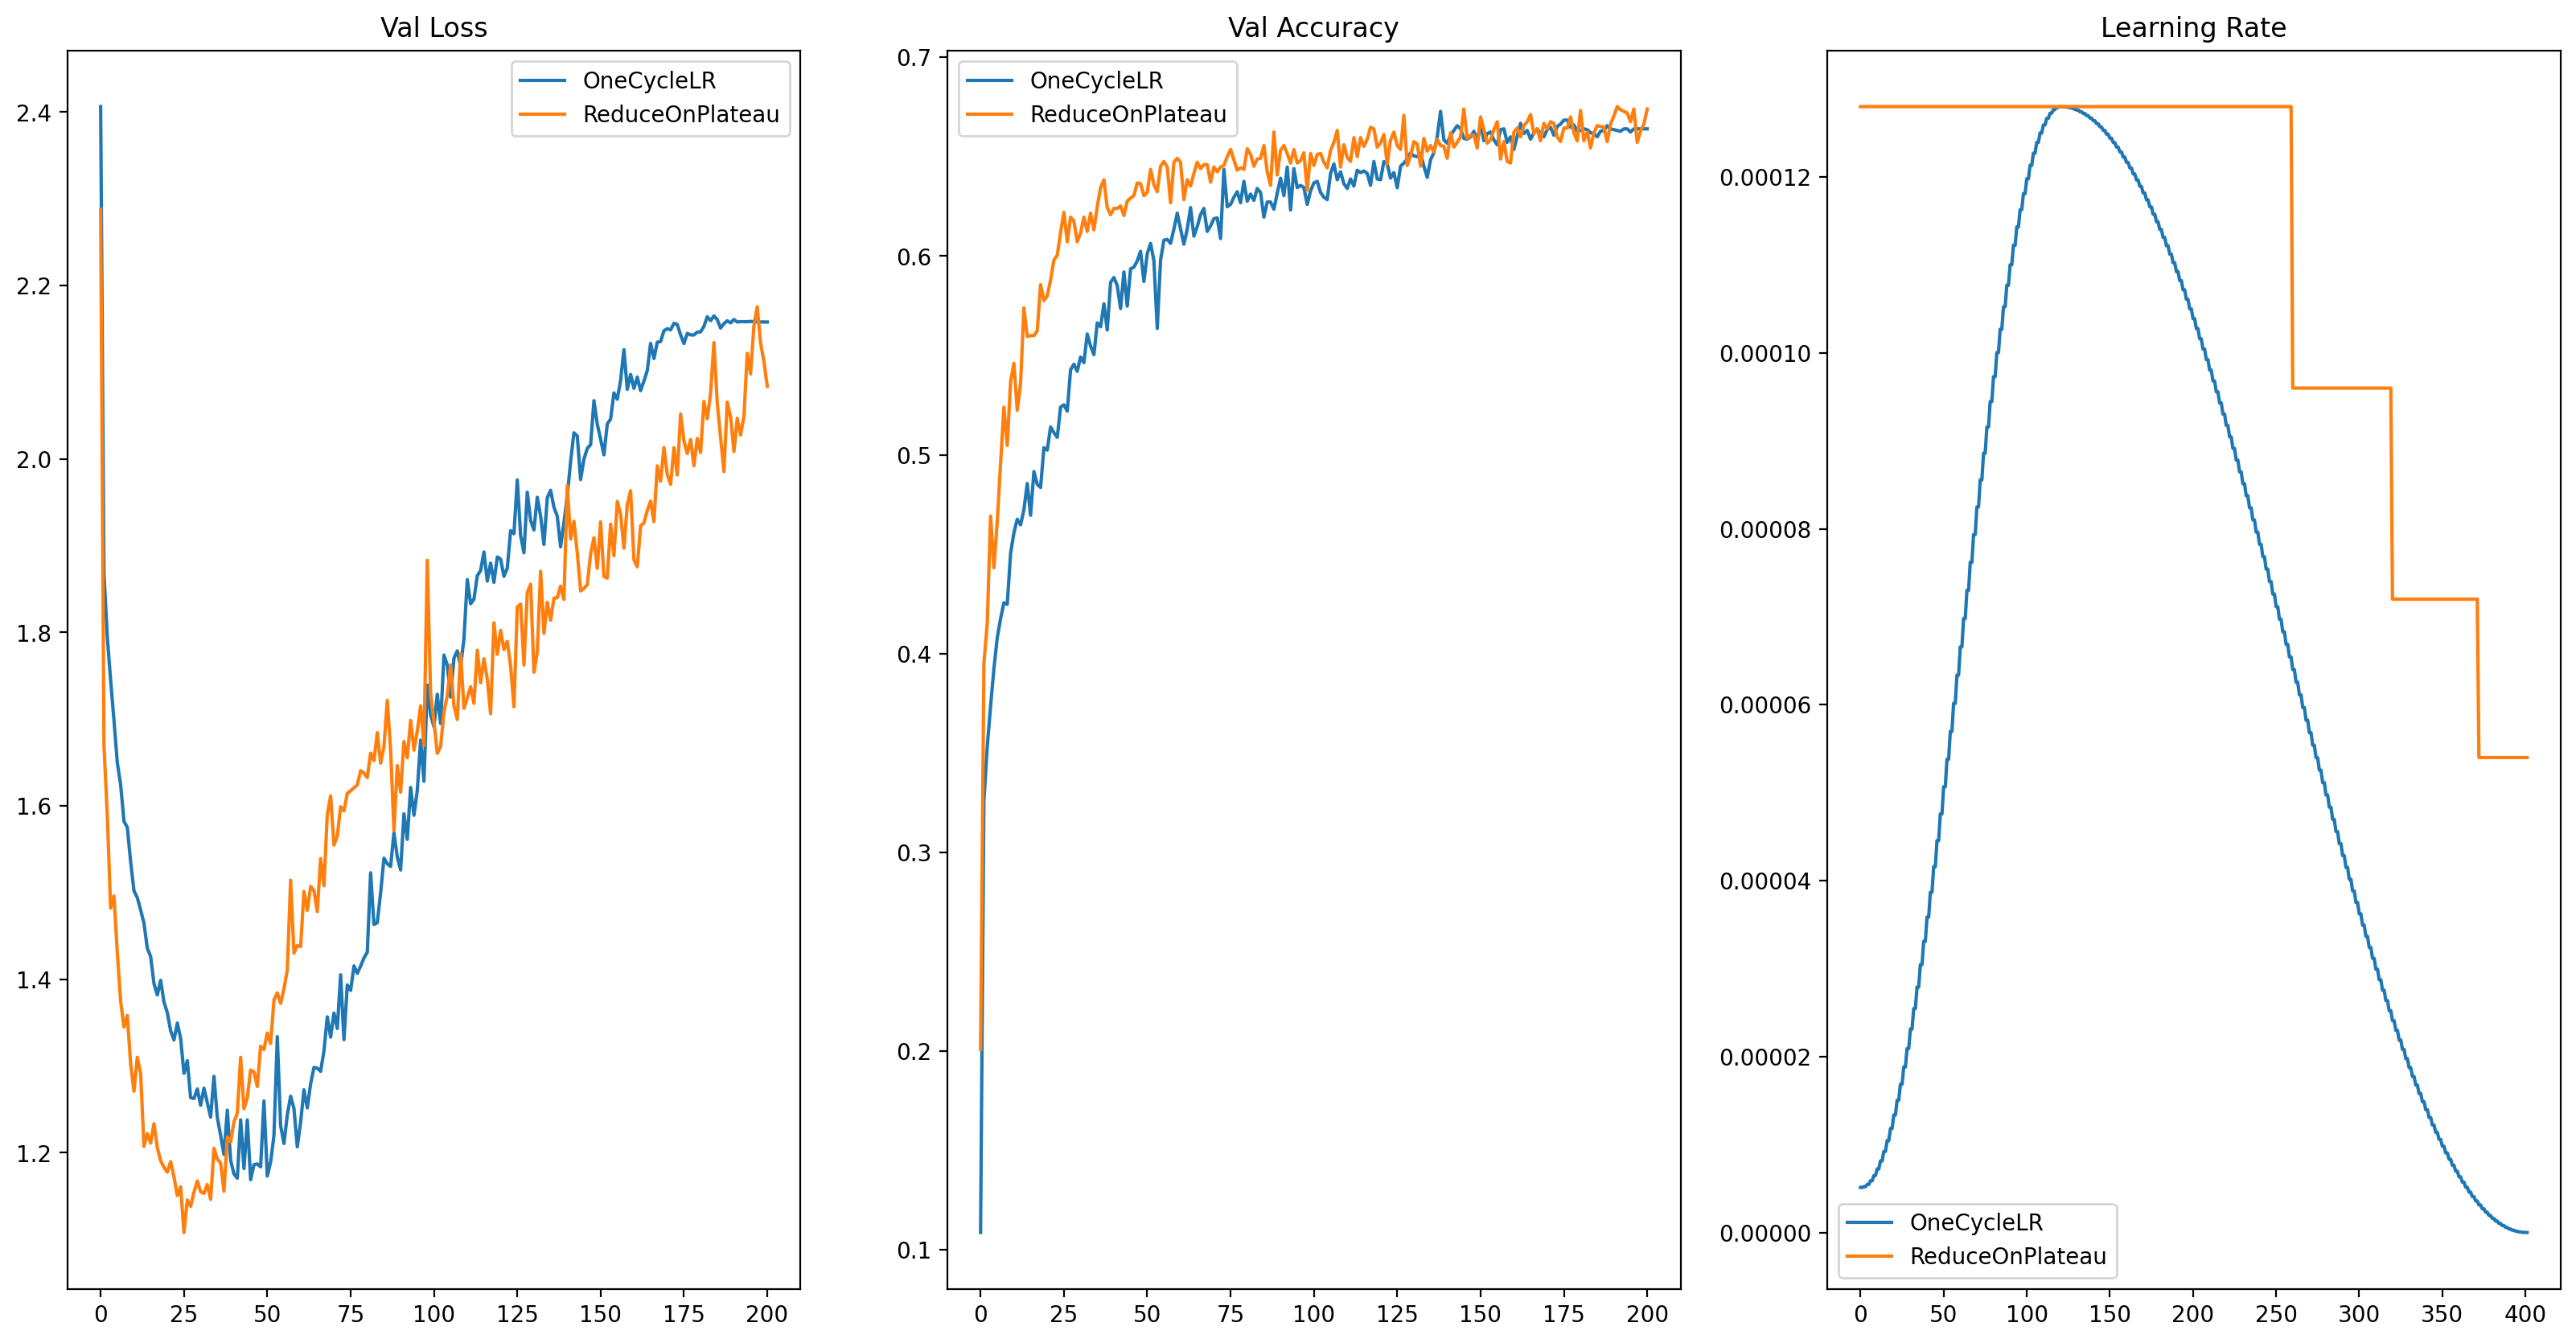

In [29]:
from torch.cuda.amp import GradScaler, autocast 
from tqdm.auto import tqdm 
import numpy as np

total_steps = 20000
eval_interval = 100
batch_size = 128
momentum = 0.0
weight_decay = 0.005
optimizer_type = 'AdamW'

exp_list = ['OneCycleLR', 'ReduceOnPlateau']
# [None, 'OneCycleLR']
set_seed(42)
import datetime

time_stamp = str(datetime.datetime.now()).replace(' ', '_').replace(':', '_').replace('.', '_')
exp_name = './results/training'
model_configs = {
    'sgd':{
        'resnet50': {
            'lr': 0.04,
            'max_lr': 0.04,
        }, 
        'swin_t':{
            'lr': 0.05,
            'max_lr': 0.05,
        }, 
        'resnet18':{
            'lr': 0.125,
            'max_lr': 0.125,
        }
    },
    # 'adamw':{
    #     'resnet50': {
    #         'lr': 0.002,
    #         'max_lr': 0.002,
    #     }, 
    #     'swin_t':{
    #         'lr': 6.4*1e-5,
    #         'max_lr': 6.4*1e-5,
    #     }, 
    #     'resnet18':{
    #         'lr': 0.001,
    #         'max_lr': 0.001,
    #     }
    # },   
    'adamw':{
        # 'resnet50': {
        #     'lr': 0.002,
        #     'max_lr': 0.002,
        # }, 
        'swin_t':{
            'lr': 1.28*1e-4,
            'max_lr': 1.28*1e-4,
        }, 
        # 'resnet18':{
        #     'lr': 0.001,
        #     'max_lr': 0.001,
        # }
    },     

}[optimizer_type.lower()]

all_results_dict = {}
for model_type in model_configs:
    all_results_dict[model_type] = {}

    for scheduler_type in exp_list:
        # print(f'Using scheduler: {scheduler_type}')
        max_lr = model_configs[model_type]['max_lr']
        if scheduler_type == 'ReduceOnPlateau':
            # lr = max_lr
            lr = lr

        else:
            lr = model_configs[model_type]['lr']

        train_loader, valid_loader, test_loader, model,\
            device, criterion, optimizer, scheduler = \
                prepare_training(model_type, scheduler_type, 
                                 batch_size=batch_size, total_steps=total_steps, 
                                 lr=lr, max_lr=max_lr, num_workers=3, 
                                 momentum=momentum, weight_decay=weight_decay, optimizer=optimizer_type)
        total_images = len(train_loader.dataset)

        steps_per_epoch = len(train_loader)
        eval_interval = steps_per_epoch if eval_interval is None else eval_interval

        train_loader_iterrator = InfiniteDataLoaderIterator(train_loader)
        metric_dict = {
            'train_loss': [],
            'train_acc': [],
            'val_step_loss': [],
            'val_step_acc': [],
            'val_step_lr': [],
            'lr': []
        }

        scaler = GradScaler()
        best_val_accuracy = 0

        model.train()
        running_loss = 0.0
        total_correct = 0
        for cur_iters in (tqdm_bar:=tqdm(range(total_steps))):

                
            # train step start
            data = next(train_loader_iterrator)
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            if scheduler_type == 'ReduceOnPlateau':
                scheduler.step(loss.item())
            else:
                scheduler.step()
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            # train step finish


            # Validation phase
            if cur_iters % eval_interval == eval_interval-1 or cur_iters == 0 or cur_iters == total_steps-1:
                save_dir = f'./{exp_name}/{time_stamp}/{model_type}'
                val_loss, val_acc = validate(model, valid_loader, criterion, device, scheduler, save_dir)        

                train_loss = running_loss/eval_interval
                train_acc = total_correct/(eval_interval*train_loader.batch_size)
            
                metric_dict['train_loss'].append(train_loss)
                metric_dict['train_acc'].append(train_acc)
                if scheduler_type == 'ReduceOnPlateau':
                    metric_dict['lr'].append(scheduler.optimizer.param_groups[0]['lr'])
                else:
                    metric_dict['lr'].append(scheduler.get_last_lr()[0])

                desc = ''
                desc += f'Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.3f}, '
                desc += f'Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.3f}'
                tqdm_bar.set_description(desc)
                running_loss = 0.0
                total_correct = 0

        # testing
        model.eval()
        total_correct = 0
        total_images = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_images += labels.size(0)
                total_correct += (predicted == labels).sum().item()
        
        desc = 'Model accuracy on 10000 test images: %d%%' % (total_correct * 100 / total_images)

        print(desc)

        all_results_dict[model_type][scheduler_type] = metric_dict

    import json
    import matplotlib.pyplot as plt
    new_dir = f'./{exp_name}/{time_stamp}'
    os.makedirs(new_dir, exist_ok=True)

    f_name = f'results_{model_type}'
    with open(f'{new_dir}/{f_name}.json', 'w') as f:
        json.dump(all_results_dict[model_type], f)

    results_dict = json.load(open(f'{new_dir}/{f_name}.json', 'r'))

    figure = plt.figure(figsize=(10, 5), dpi=200)
    
    scheduler_type_list = sorted(list(results_dict.keys()))


    # subplots
    fig, ax = plt.subplots(1, 3, figsize=(20, 10), dpi=200)
    ax[0].set_title('Val Loss')
    # ax[0].plot(lr_list, train_loss, label='Train')
    for i, sch in enumerate(scheduler_type_list):
        ax[0].plot(results_dict[sch]['val_step_loss'], label=sch)
    ax[0].legend()


    ax[1].set_title('Val Accuracy')
    for i, sch in enumerate(scheduler_type_list):
        ax[1].plot(results_dict[sch]['val_step_acc'], label=sch)
    ax[1].legend()

    ax[2].set_title('Learning Rate')
    for i, sch in enumerate(scheduler_type_list):
        ax[2].plot(results_dict[sch]['lr'], label=sch)
    ax[2].legend()

    fig.savefig(f'{exp_name}/{time_stamp}/{f_name}.png')
    # plt.savefig(f'./lr_test/{time_stamp}/{f_name}.png')
    plt.show()


global_configs = {
    'total_steps': total_steps,
    'eval_interval': eval_interval,
    'batch_size': batch_size,
    'max_lr': max_lr,
    'len_train': len(train_dataset),
    'len_val': len(valid_dataset),
    'momentum': momentum,
    'weight_decay': weight_decay,
    'optimizer': optimizer_type,
} 
with open(f'{exp_name}/{time_stamp}/global_configs.json', 'w') as f:
    json.dump(global_configs, f)

Using scheduler: LinearLR


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

/home/dijkstraz/anaconda3/envs/llm/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Model accuracy on 10000 test images: 47%
Using scheduler: None


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Model accuracy on 10000 test images: 46%
Using scheduler: OneCycleLR


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Model accuracy on 10000 test images: 27%


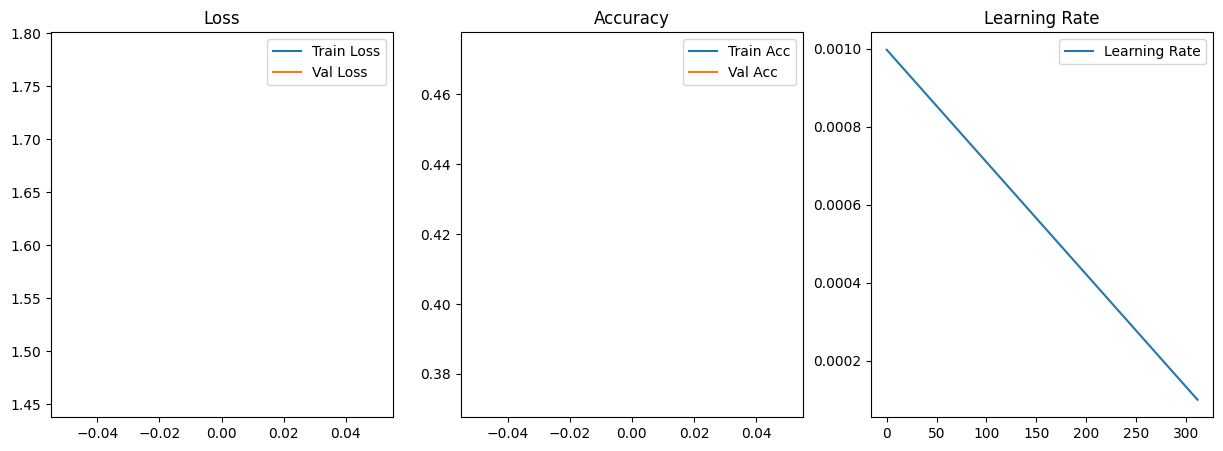

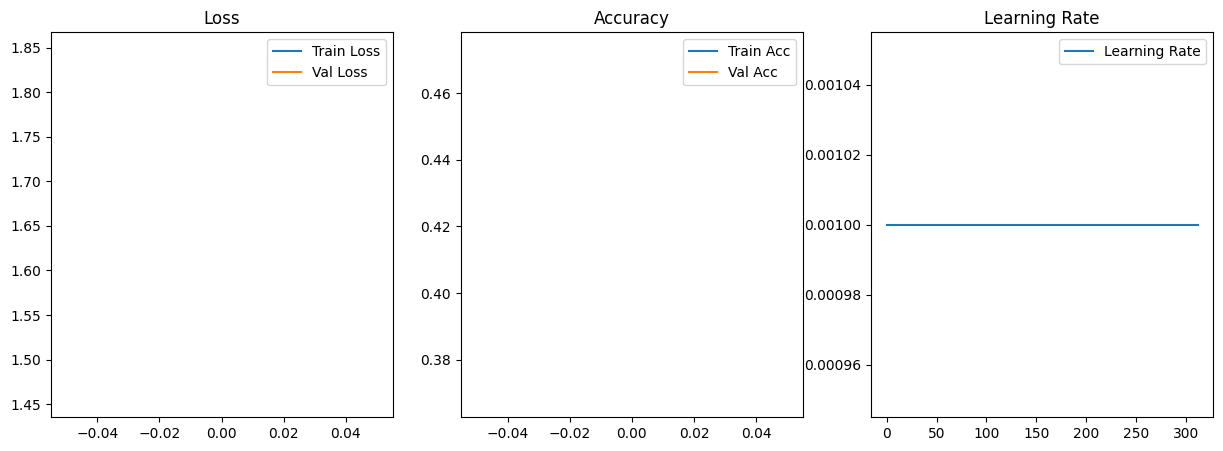

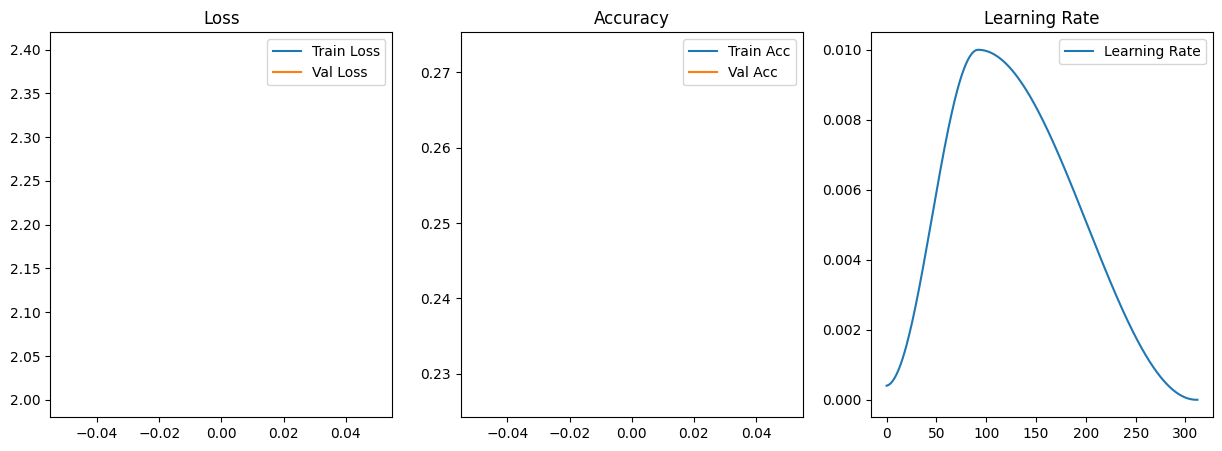

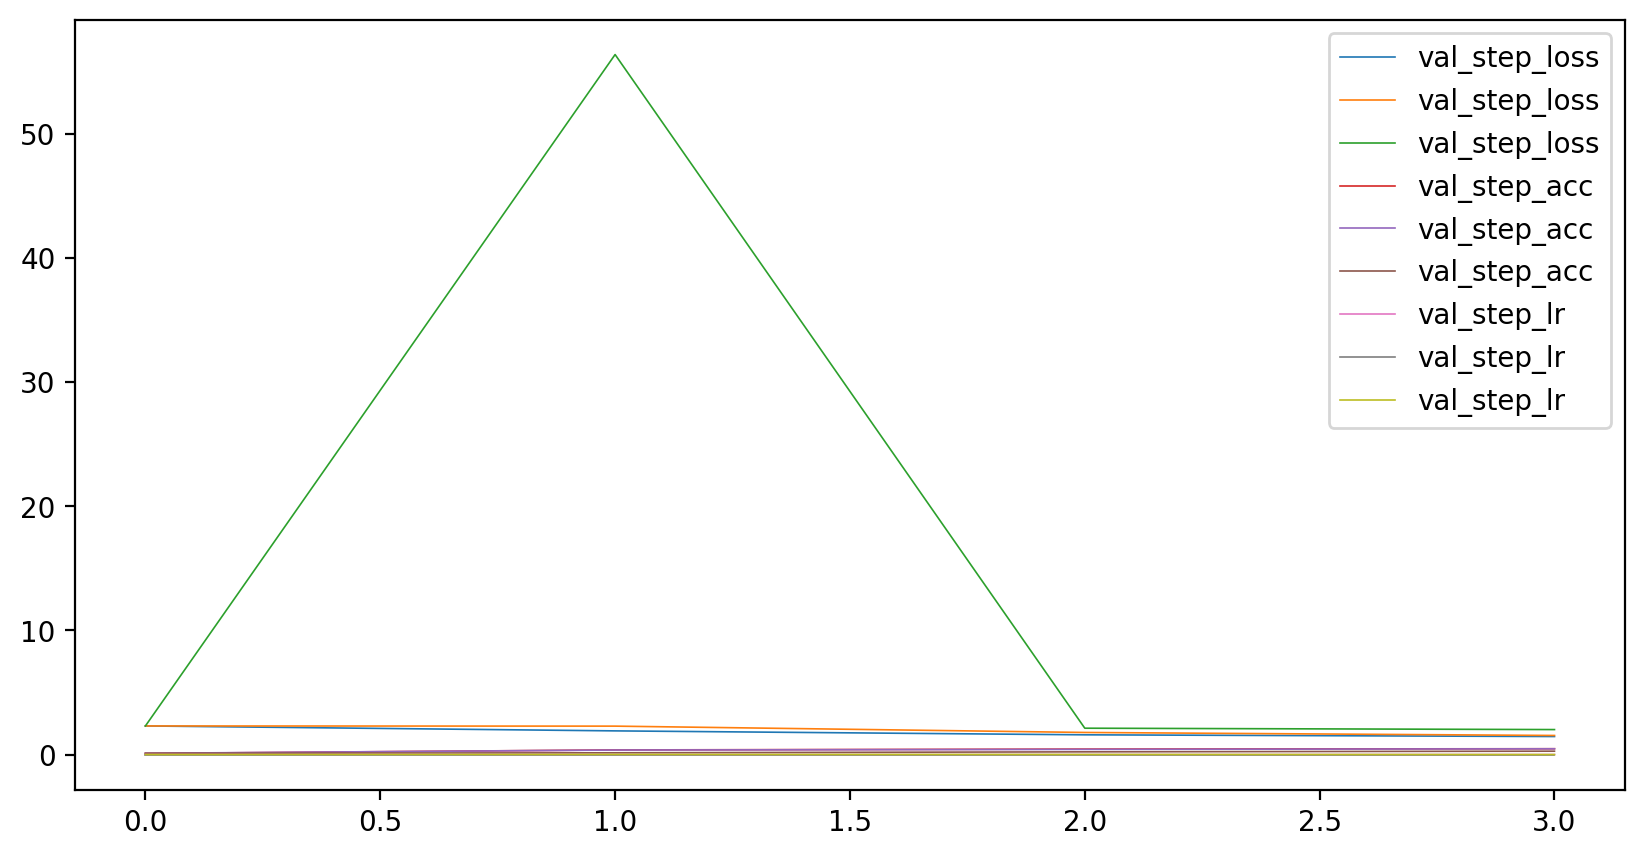

Using scheduler: LinearLR


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Model accuracy on 10000 test images: 47%
Using scheduler: None


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Model accuracy on 10000 test images: 45%
Using scheduler: OneCycleLR


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Model accuracy on 10000 test images: 35%


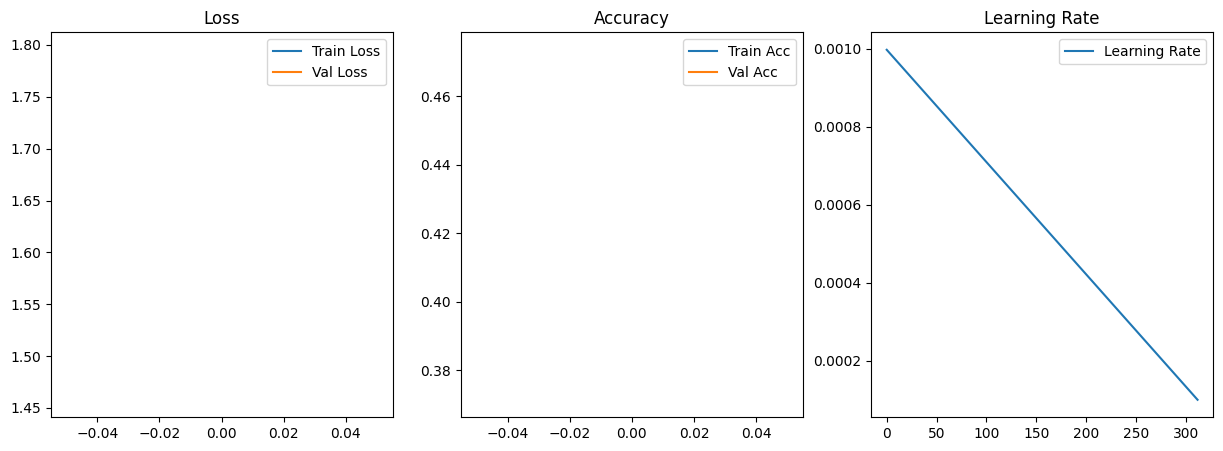

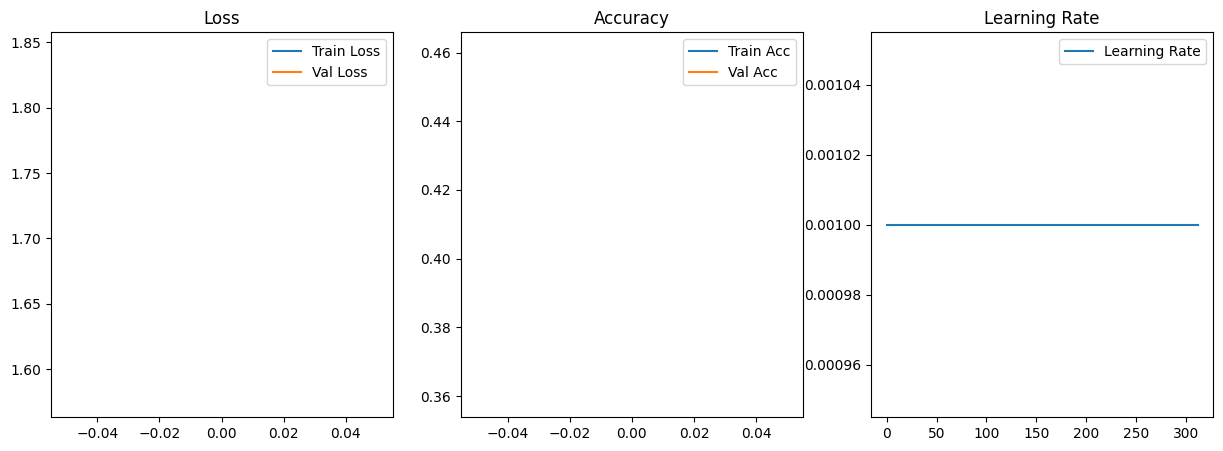

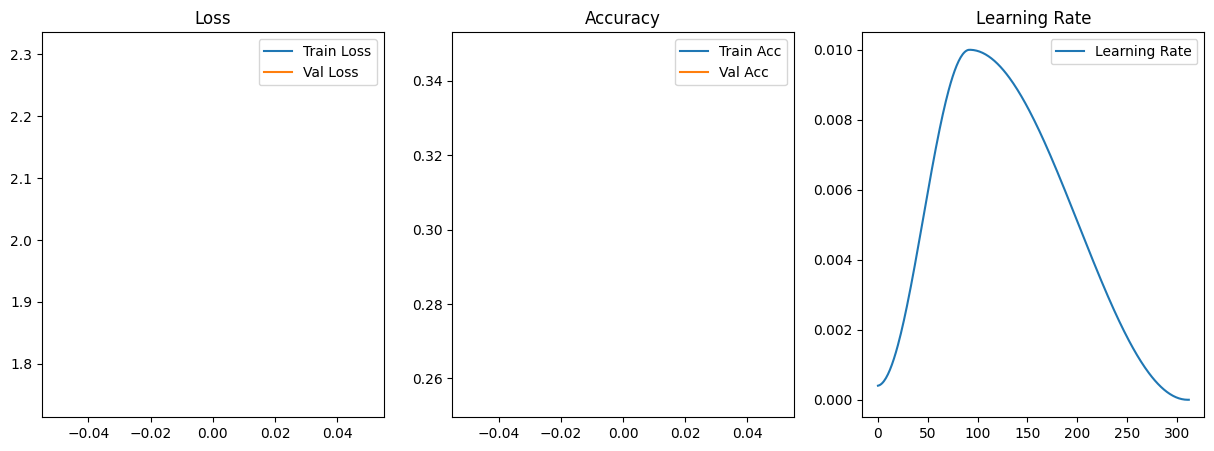

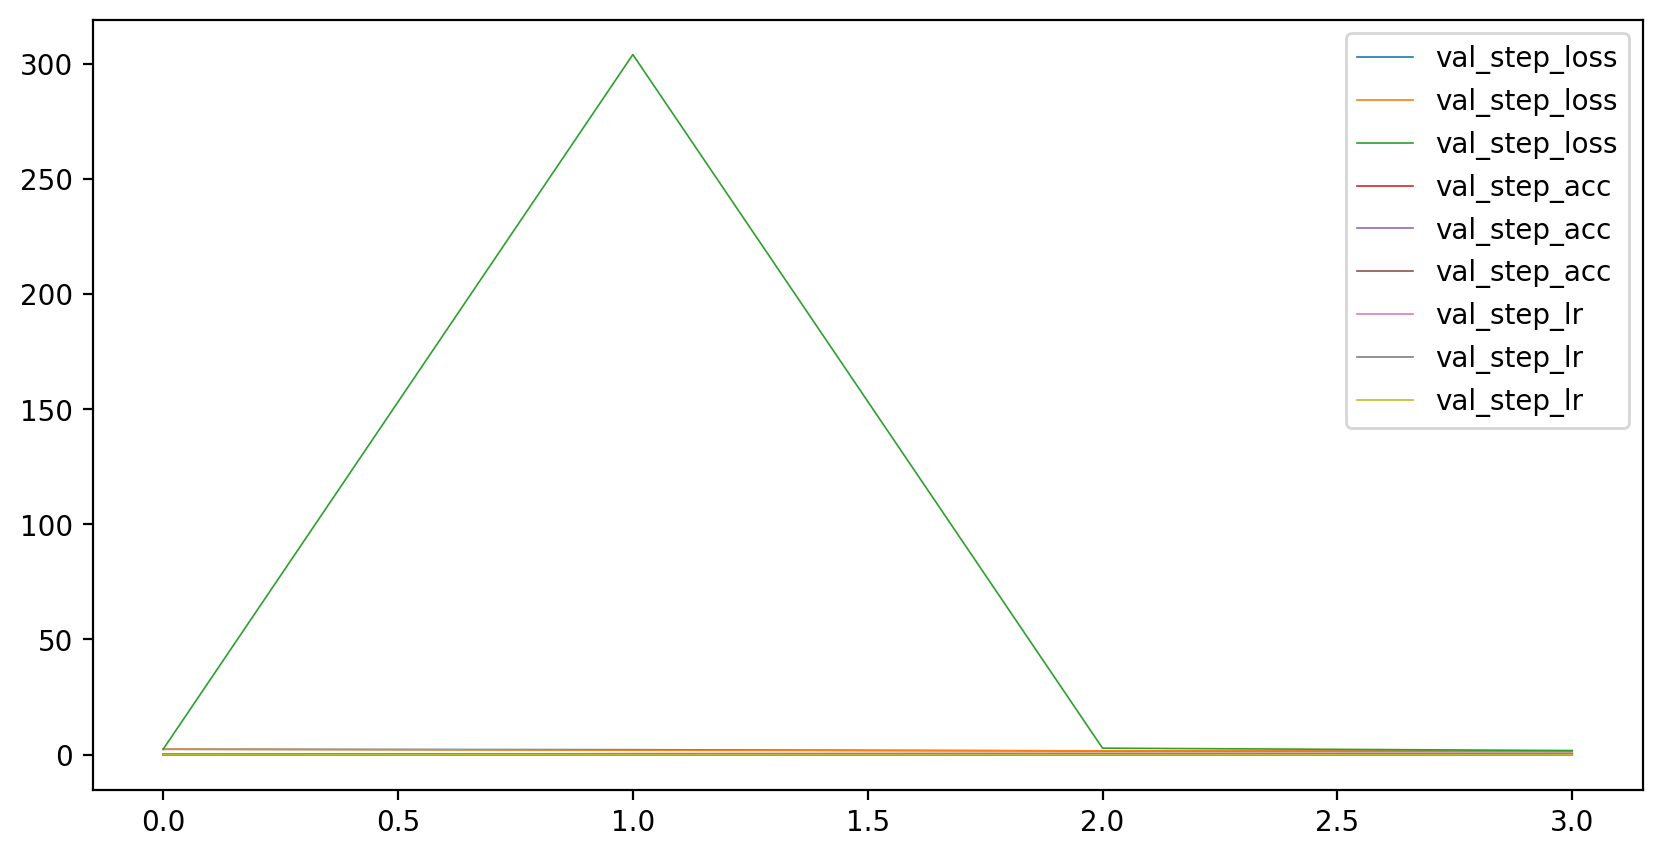

Using scheduler: LinearLR


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Model accuracy on 10000 test images: 46%
Using scheduler: None


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Model accuracy on 10000 test images: 44%
Using scheduler: OneCycleLR


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Model accuracy on 10000 test images: 34%


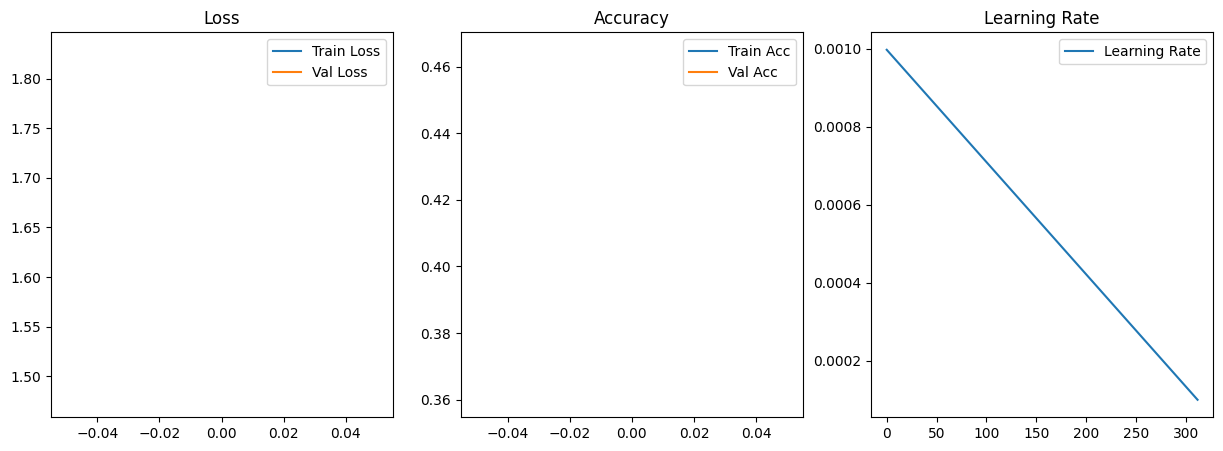

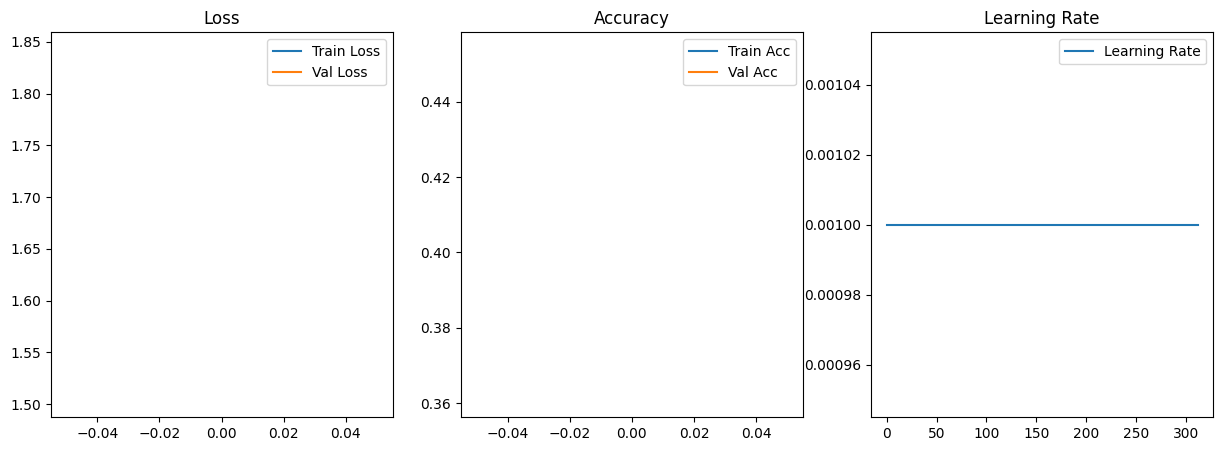

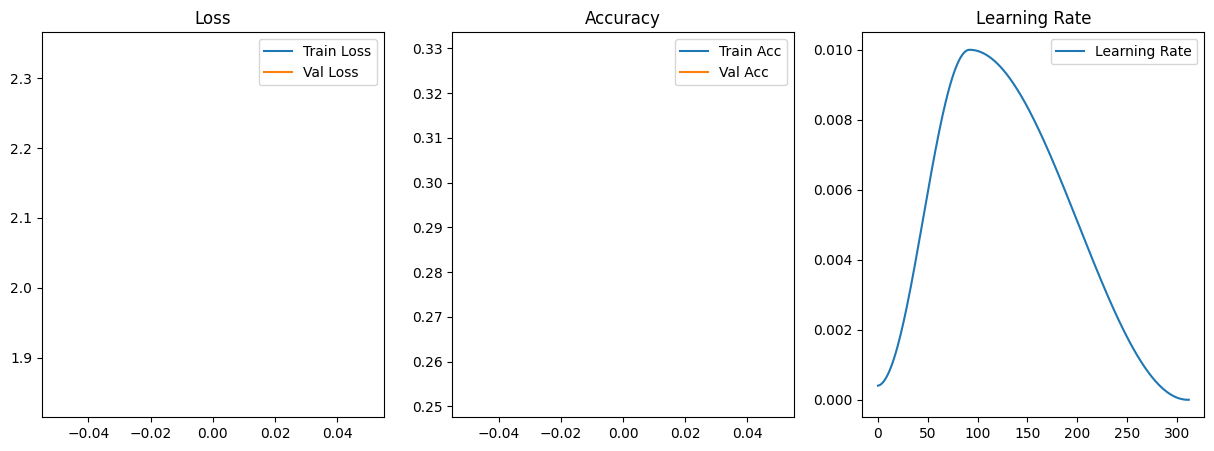

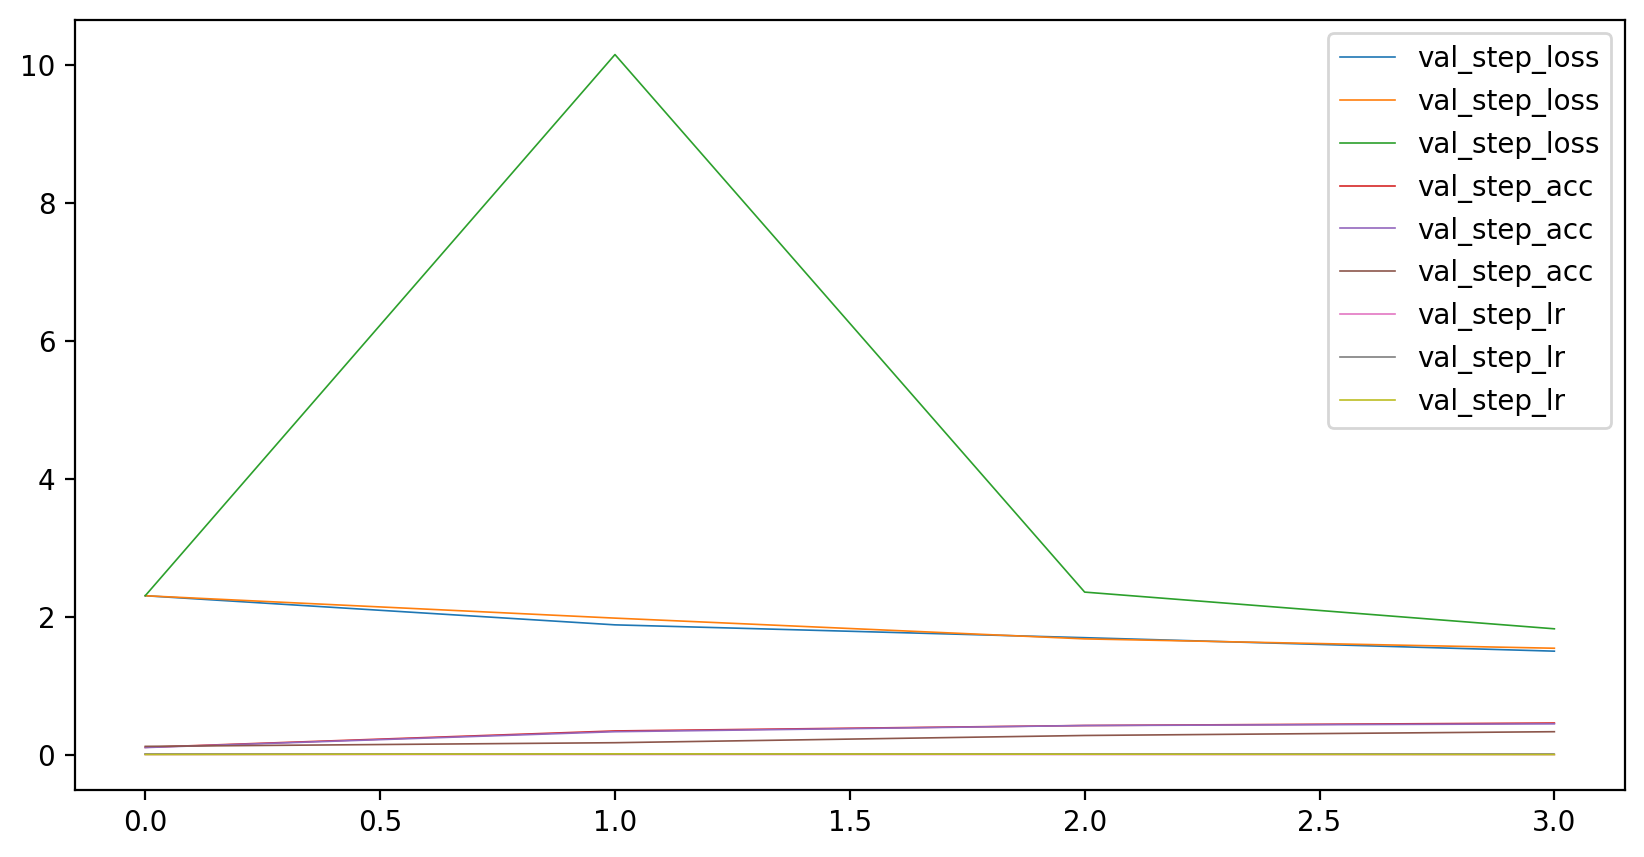

Using scheduler: LinearLR


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Model accuracy on 10000 test images: 46%
Using scheduler: None


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Model accuracy on 10000 test images: 44%
Using scheduler: OneCycleLR


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Model accuracy on 10000 test images: 33%


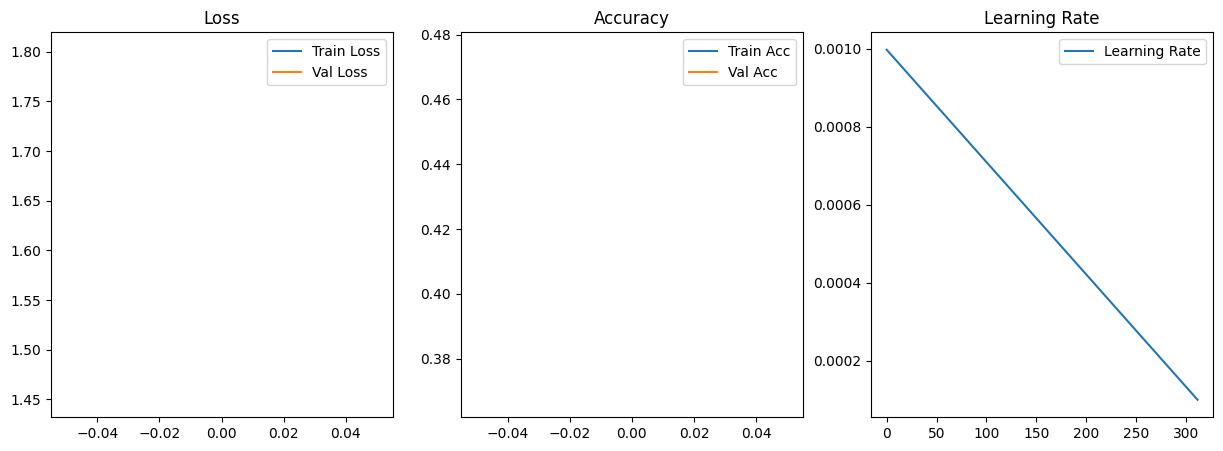

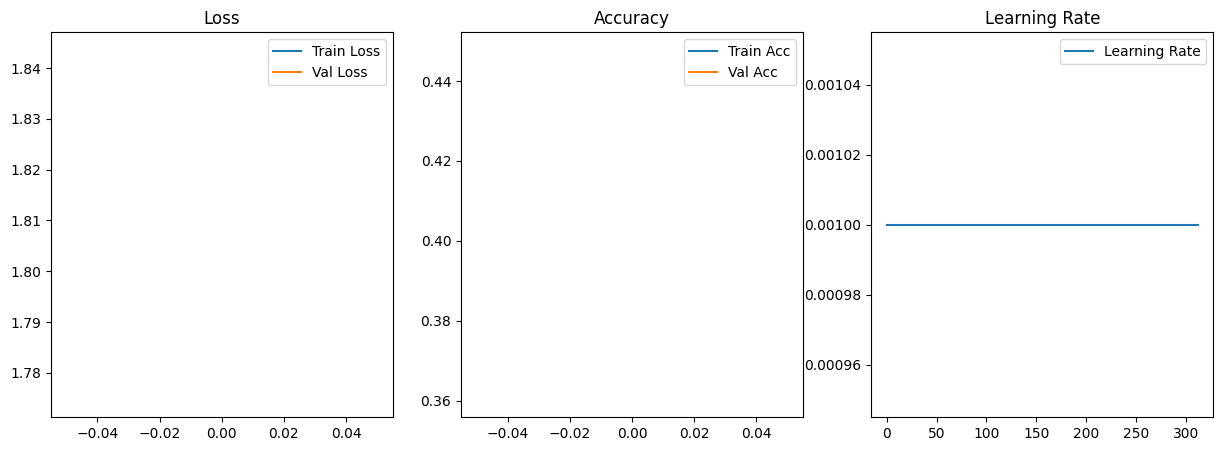

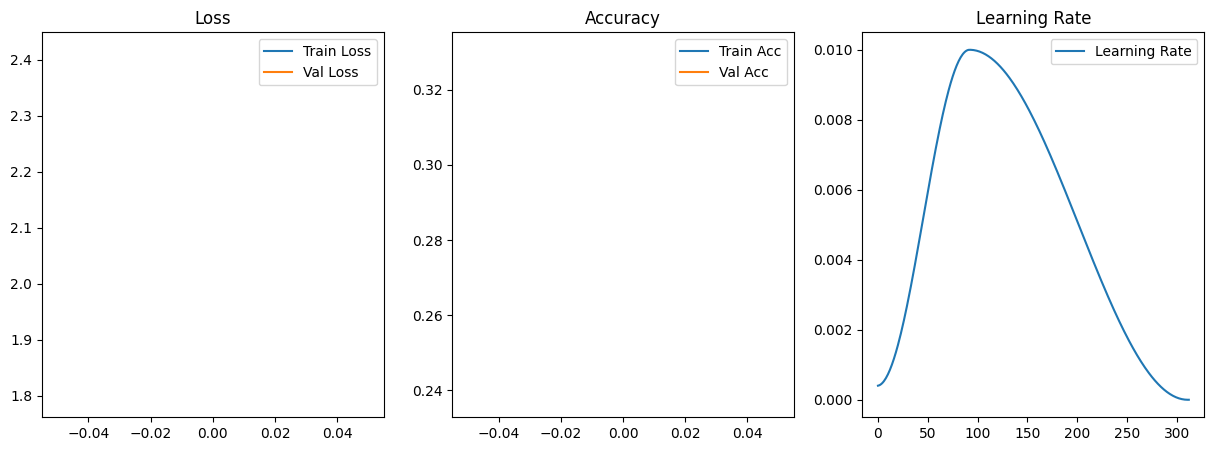

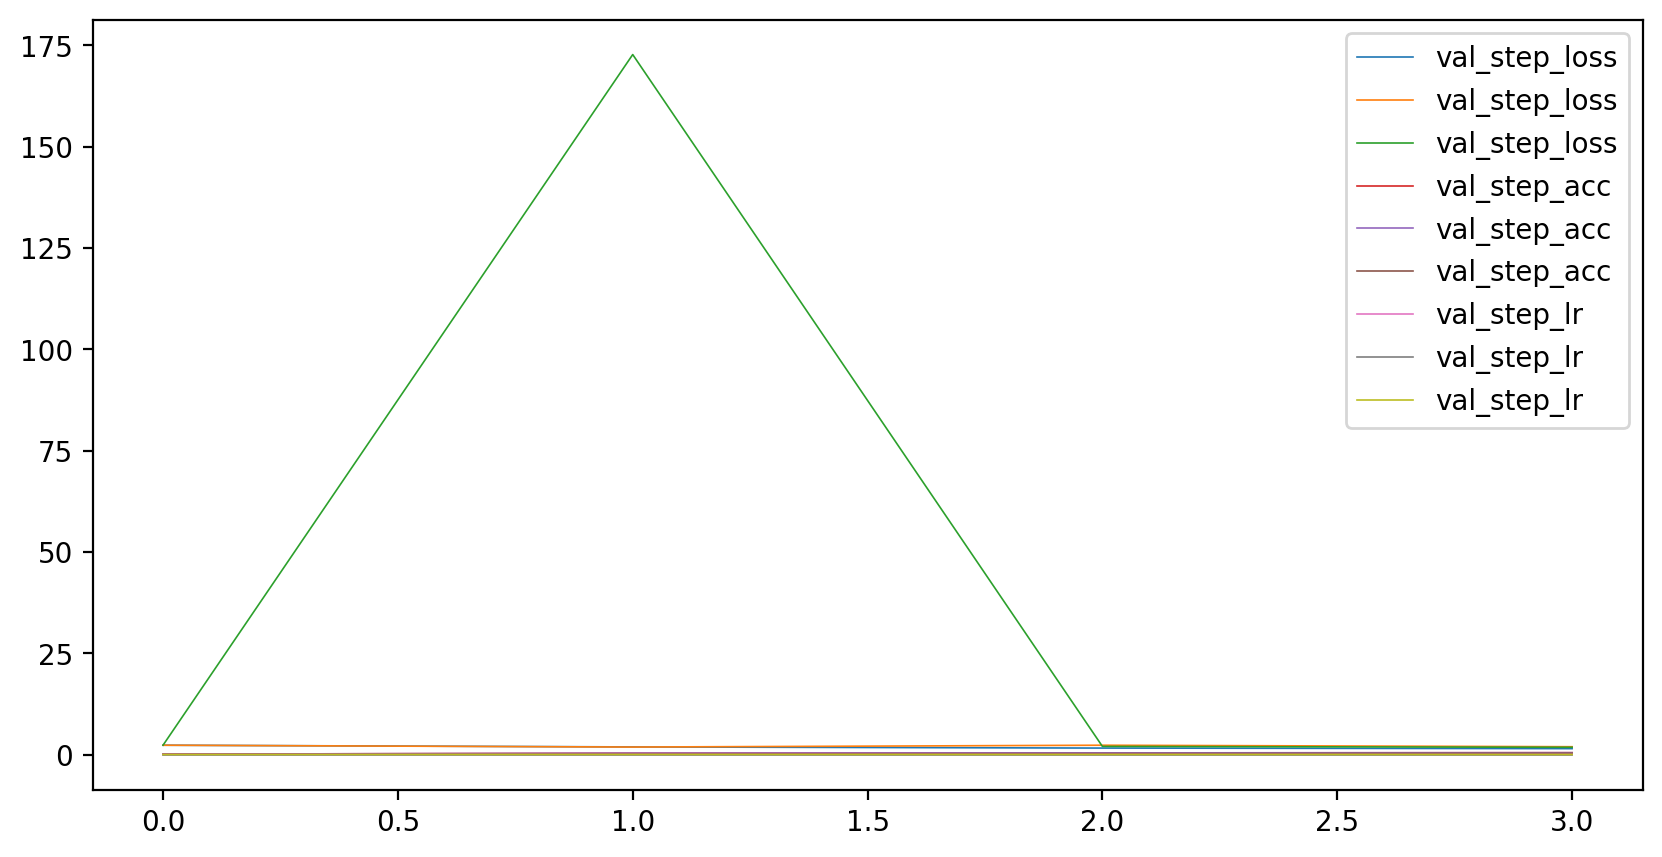

Using scheduler: LinearLR


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Model accuracy on 10000 test images: 47%
Using scheduler: None


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Model accuracy on 10000 test images: 41%
Using scheduler: OneCycleLR


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Model accuracy on 10000 test images: 41%


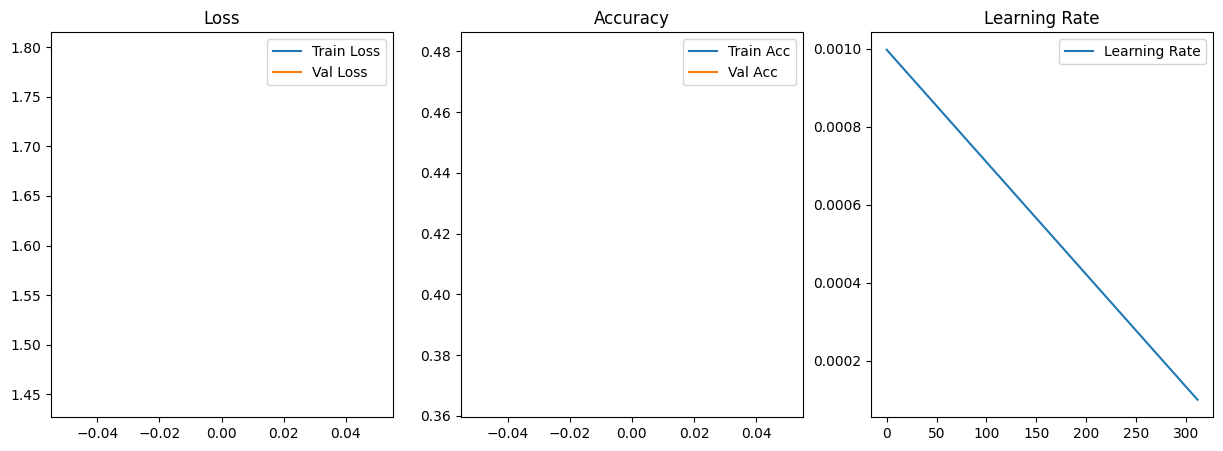

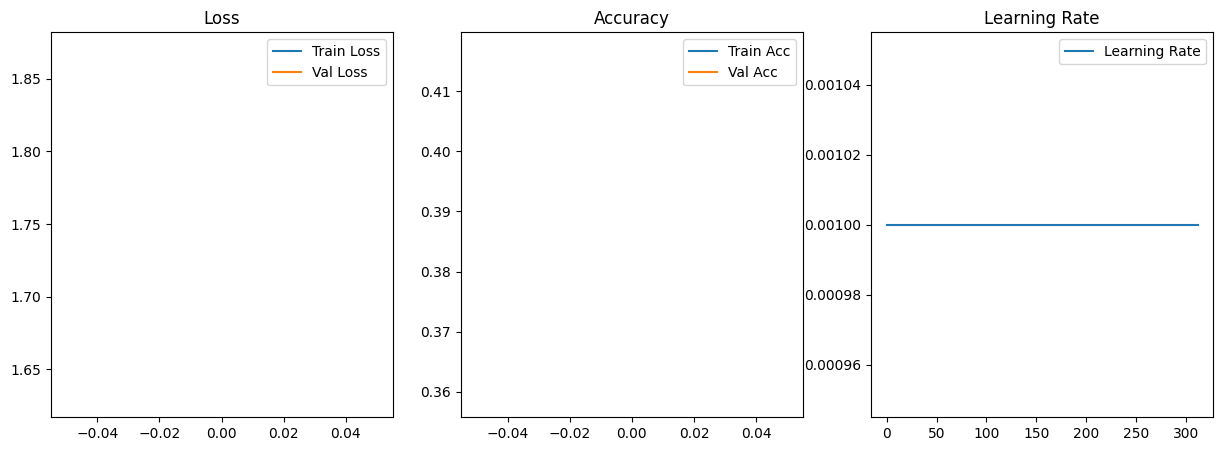

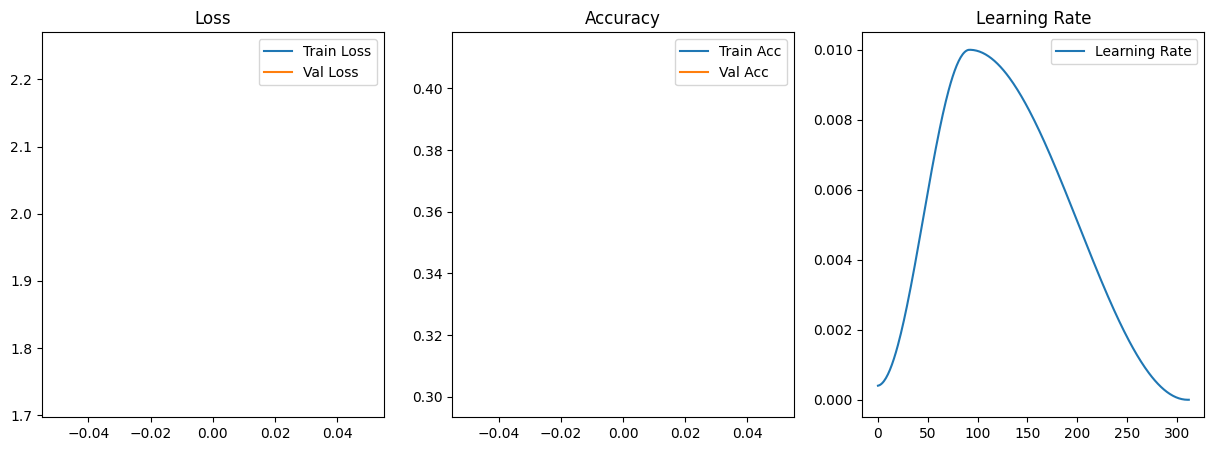

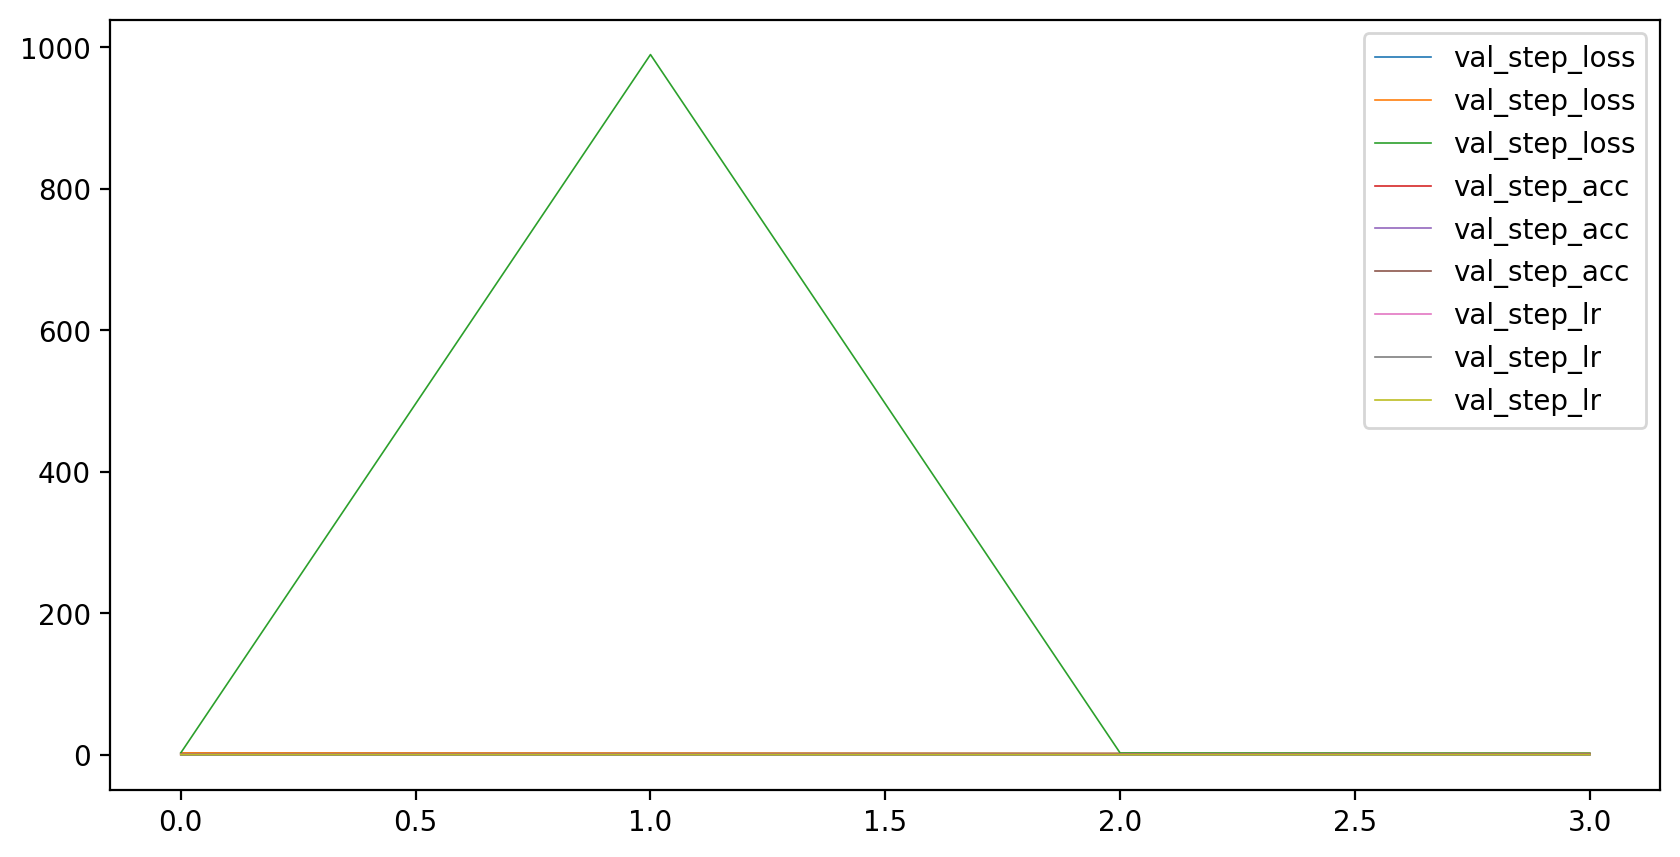

In [6]:
# from torch.cuda.amp import GradScaler, autocast 
# from tqdm.auto import tqdm 

# epochs = 20
# lr = 0.001
# max_lr = 0.01
# eval_interval = 100

# exp_list = ['LinearLR', None, 'OneCycleLR']
# # [None, 'OneCycleLR']
# all_val_step_dict = {}
# for seed in range(5):
#     set_seed(seed)
#     for scheduler_type in exp_list:
#         print(f'Using scheduler: {scheduler_type}')
#         train_loader, valid_loader, test_loader, model,\
#             device, criterion, optimizer, scheduler = \
#                 prepare_training(scheduler_type, epochs=epochs, lr=lr, max_lr=max_lr)
#         metric_dict = {
#             'train_loss': [],
#             'train_acc': [],
#             'val_step_loss': [],
#             'val_step_acc': [],
#             'val_step_lr': [],
#             'val_loss': [],
#             'val_acc': [],
#             'lr': []
#         }

#         scaler = GradScaler()
#         best_val_accuracy = 0
#         for epoch in (tqdm_bar := tqdm(range(epochs))):
#             model.train()

#             desc = f'Epoch {epoch+1}/{epochs}, '
#             running_loss = 0.0
#             total_correct = 0
#             total_images = 0
#             for i, data in tqdm(enumerate(train_loader), total=len(train_loader), leave=False):
#                 inputs, labels = data[0].to(device), data[1].to(device)

#                 optimizer.zero_grad()


#                 with autocast():
#                     outputs = model(inputs)
#                     loss = criterion(outputs, labels)

#                 scaler.scale(loss).backward()
#                 scaler.step(optimizer)

#                 scheduler.step()
#                 metric_dict['lr'].append(scheduler.get_last_lr()[0])

#                 scaler.update()

#                 running_loss += loss.item()
#                 _, predicted = torch.max(outputs, 1)
#                 total_images += labels.size(0)
#                 total_correct += (predicted == labels).sum().item()

#                 # Validation phase
#                 if i % eval_interval == 0:
#                     model.eval()
#                     val_running_loss = 0.0
#                     val_total_correct = 0
#                     val_total_images = 0
#                     with torch.no_grad():
#                         for i, data in enumerate(valid_loader):
#                             images, labels = data[0].to(device), data[1].to(device)
#                             outputs = model(images)
#                             loss = criterion(outputs, labels)
#                             val_running_loss += loss.item()
#                             _, predicted = torch.max(outputs.data, 1)
#                             val_total_images += labels.size(0)
#                             val_total_correct += (predicted == labels).sum().item()
#                         current_val_accuracy = val_total_correct / val_total_images                
#                         metric_dict['val_step_loss'].append(val_running_loss/(i+1))
#                         metric_dict['val_step_acc'].append(current_val_accuracy)
#                         metric_dict['val_step_lr'].append(scheduler.get_last_lr()[0])
#                 model.train()
            

#             desc += f'Train Loss: {running_loss/(i+1):.3f}, Train Acc: {total_correct/total_images:.3f}, '
#             metric_dict['train_loss'].append(running_loss/(i+1))
#             metric_dict['train_acc'].append(total_correct/total_images)


#             # Validation phase
#             model.eval()
#             val_running_loss = 0.0
#             val_total_correct = 0
#             val_total_images = 0
#             with torch.no_grad():
#                 for i, data in enumerate(valid_loader):
#                     images, labels = data[0].to(device), data[1].to(device)
#                     outputs = model(images)
#                     loss = criterion(outputs, labels)
#                     val_running_loss += loss.item()
#                     _, predicted = torch.max(outputs.data, 1)
#                     val_total_images += labels.size(0)
#                     val_total_correct += (predicted == labels).sum().item()
#                 current_val_accuracy = val_total_correct / val_total_images
#                 metric_dict['val_loss'].append(val_running_loss/(i+1))
#                 metric_dict['val_acc'].append(current_val_accuracy)
#             model.train()
            

            

#             desc += f'Val Loss: {val_running_loss/(i+1):.3f}, Val Acc: {current_val_accuracy:.3f}'
            

#             tqdm_bar.set_description(desc)

#             # Update the best model if current validation accuracy is better
#             if current_val_accuracy > best_val_accuracy:
#                 best_val_accuracy = current_val_accuracy
#                 os.makedirs(f'./checkpoints/{scheduler_type}', exist_ok=True)
#                 torch.save(model.state_dict(), f'./checkpoints/{scheduler_type}/best_{seed}_model.pth')
                
#         import matplotlib.pyplot as plt

#         fig, ax = plt.subplots(1, 3, figsize=(15, 5))
#         ax[0].plot(metric_dict['train_loss'], label='Train Loss')
#         ax[0].plot(metric_dict['val_loss'], label='Val Loss')
#         ax[0].set_title('Loss')
#         ax[0].legend()

#         ax[1].plot(metric_dict['train_acc'], label='Train Acc')
#         ax[1].plot(metric_dict['val_acc'], label='Val Acc')
#         ax[1].set_title('Accuracy')
#         ax[1].legend()

#         ax[2].plot(metric_dict['lr'], label='Learning Rate')
#         ax[2].set_title('Learning Rate')
#         ax[2].legend()
#         plt.savefig(f'./plots/{scheduler_type}.png')
#         # plt.show()

#         all_val_step_dict[scheduler_type] = {'val_step_loss': metric_dict['val_step_loss'],
#                                             'val_step_acc': metric_dict['val_step_acc'],
#                                             'val_step_lr': metric_dict['val_step_lr']}

#         model.eval()
#         total_correct = 0
#         total_images = 0
#         with torch.no_grad():
#             for data in test_loader:
#                 images, labels = data[0].to(device), data[1].to(device)
#                 outputs = model(images)
#                 _, predicted = torch.max(outputs.data, 1)
#                 total_images += labels.size(0)
#                 total_correct += (predicted == labels).sum().item()

#         print('Model accuracy on 10000 test images: %d%%' % (total_correct * 100 / total_images))

#     import json
#     import datetime
#     time_stamp = str(datetime.datetime.now()).replace(' ', '_').replace(':', '_').replace('.', '_')
#     new_dir = f'./all_results/{time_stamp}'
#     os.makedirs(new_dir, exist_ok=True)

#     with open(f'{new_dir}/results_{seed}.json', 'w') as f:
#         json.dump(all_val_step_dict, f)

#     results_dict = json.load(open(f'{new_dir}/results_{seed}.json', 'r'))

#     figure = plt.figure(figsize=(10, 5), dpi=200)
#     exp_results_keys = list(results_dict.values())[0].keys()    
#     for key in exp_results_keys:
#         for exp in results_dict:
#             val = results_dict[exp][key]
#             plt.plot(val, label=key, linewidth=0.6)
#         plt.legend()
#     plt.savefig(f'./plots/{seed}.png')
#     plt.show()

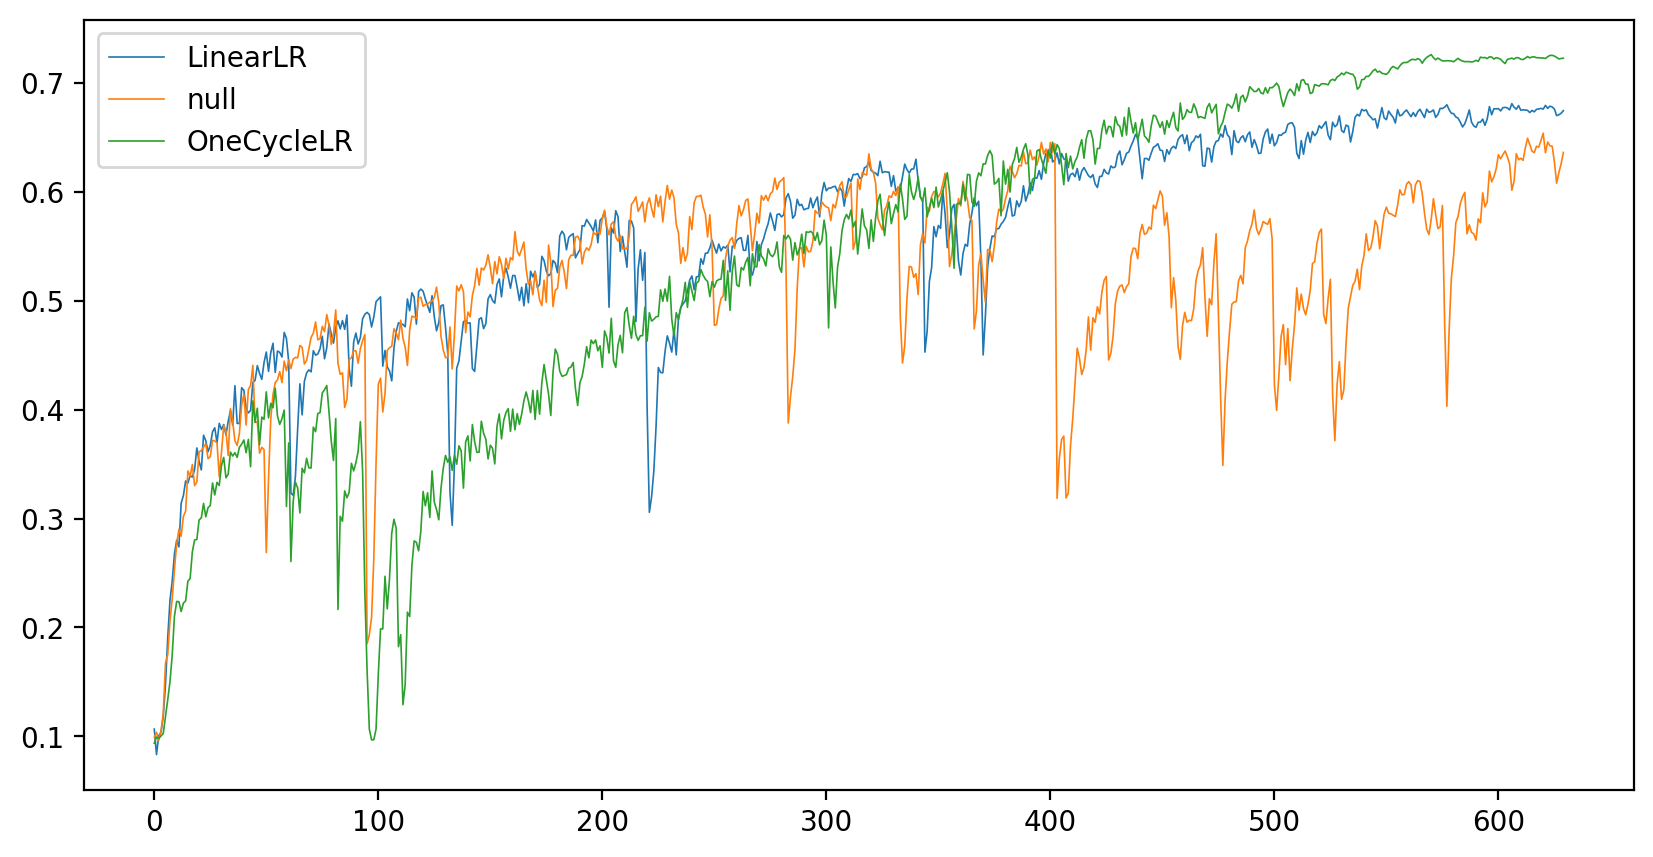

# Check Results

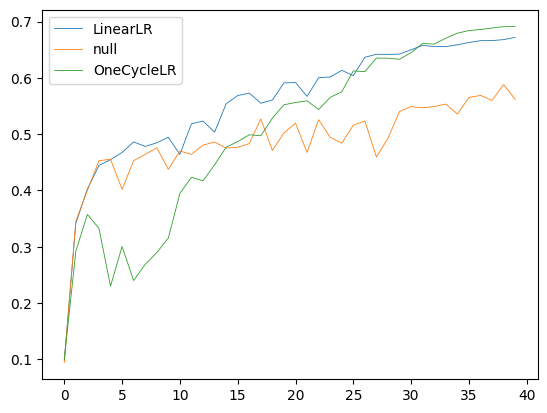

In [13]:
import glob
import json
import numpy as np

results = {}
for js in glob.glob("./results_*"):
    with open(js, 'r') as f:
        curves = json.load(f)

    for key, val in curves.items():
        if key not in results:
            results[key] = []
        results[key].append(val)
    
for key, val in results.items():
    val = np.array(val).mean(axis=0)

    plt.plot(val, label=key, linewidth=0.6)
plt.legend()
plt.savefig(f'./plots/{seed}.png')
plt.show()